<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____




```
# This is formatted as code
```

### Full Name : Neda Fallah
### Student Number : 98100226
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [2]:
#run this cell to download and prepare data
import data_utils
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

efigi_png downloaded!
efigi_tables downloaded!


,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


In [4]:
y= df['class_label']
X=df['name']

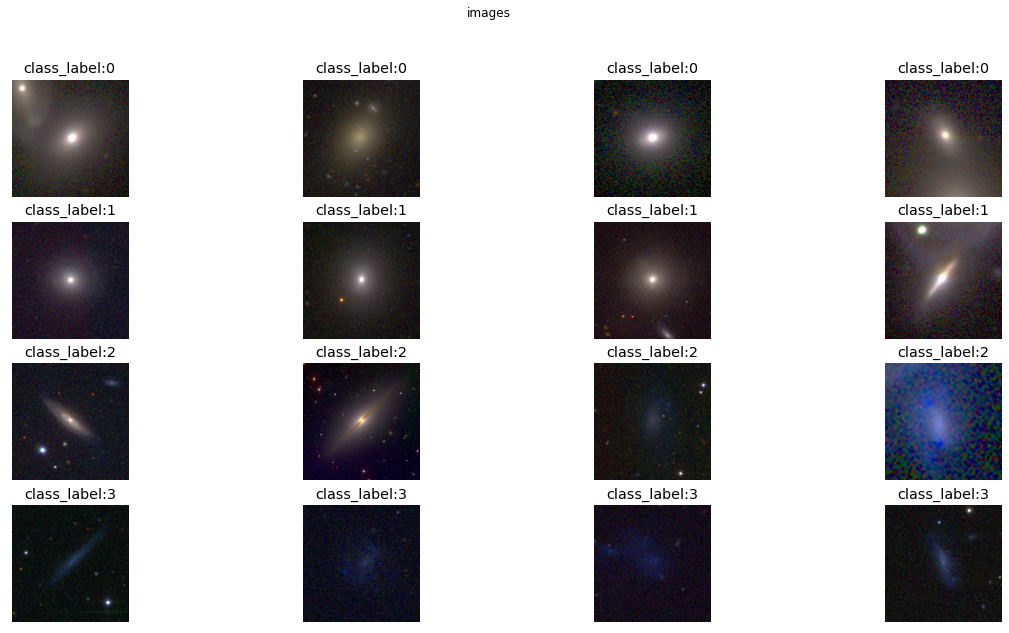

In [5]:
import matplotlib.pyplot as plt 

num_row=4 
num_col=4

fig, axes = plt.subplots(num_row, num_col, figsize=(20,10))
for i in range(4): 
   new_df = df[df.class_label==i].head(4) 
   name_list = list(new_df["name"]) 
   for j in range(4): 
      s = name_list[j] 
      address = '/content/efigi-1.6/png/'+s+'.png' 
      img = plt.imread(address) 
      ax = axes[i,j]
      ax.imshow(img) 
      ax.set_xticks([]) 
      ax.set_yticks([]) 
      ax.set_title("class_label:{}".format(i)) 
 
plt.suptitle("images") 
plt.savefig('samples.png', bbox_inches='tight') 
plt.show()

# Define Dataset (20 Points)

In [6]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################
from torchvision.io import read_image 
import torchvision.transforms as T 
import cv2 as cv

   

class GalaxyDataSet(Dataset):
    def __init__(self, base_dataset, transform):
        pass
        self.base_dataset = base_dataset
        self.transform = transform


    def __len__(self):
        pass
        return len(self.base_dataset)

    def __getitem__(self,index):
        pass
        target = self.base_dataset.iloc[index,2]
        name = self.base_dataset.iloc[index,0]
        # read the png image 
      
        pic= cv.imread('/content/efigi-1.6/png/'+ name +'.png')
        pic = cv.cvtColor(img , cv.COLOR_BGR2RGB)
        
        return self.transform(pic), target


In [7]:
from sklearn.model_selection import train_test_split
#split to train, test and validation sets
train=df.sample(frac=0.8,random_state=200)
valid=df.sample(frac=0.2,random_state=200)
train = train.drop(valid.index)
test=df.drop(train.index)

#X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0], df.iloc[:, 2], , test_size=0.33, random_state=42)

In [8]:
#transform the datasets using data transformer
train_dataset =  GalaxyDataSet(train, transforms.ToTensor())
valid_dataset =  GalaxyDataSet(valid, transforms.ToTensor())
test_dataset  =  GalaxyDataSet(test , transforms.ToTensor())

In [9]:
num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,                # <-- this reshuffles the data at every epoch
                                          num_workers=num_threads)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_threads)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_threads)


print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))

The train set contains 2674 images, in 21 batches
The validation set contains 892 images, in 7 batches
The test set contains 1784 images, in 14 batches


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Define Model (20 Points)

In [10]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

def linear_relu(dim_in, dim_out):
    return [nn.Linear(dim_in, dim_out),
            nn.ReLU(inplace=True)]

class ClassifierModel(nn.Module):

    def __init__(self, input_size, num_classes):
        super(ClassifierModel, self).__init__()
        self.classifier =  nn.Sequential(
            *linear_relu(input_size, 256),
            *linear_relu(256, 256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size()[0], -1)  #همون فلتن
        y = self.classifier(x)
        return y


# Train Model (30 Points)

In [11]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################

def train(model, loader, f_loss, optimizer, device):
    """
    Train a model for one epoch, iterating over the loader
    using the f_loss to compute the loss and the optimizer
    to update the parameters of the model.

    Arguments :

        model     -- A torch.nn.Module object
        loader    -- A torch.utils.data.DataLoader
        f_loss    -- The loss function, i.e. a loss Module
        optimizer -- A torch.optim.Optimzer object
        device    -- a torch.device class specifying the device
                     used for computation

    Returns :
    """
    # We enter train mode.
    # it is important for layers such as dropout, batchnorm, ...
    model.train()

    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute the forward pass through the network up to the loss
        outputs = model(inputs)
        loss = f_loss(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [12]:
model=ClassifierModel(3*255*255, 4)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
f_loss = torch.nn.CrossEntropyLoss()

# Test Model (20)

In [13]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

def test(model, loader, f_loss, device):
    """
    Test a model by iterating over the loader

    Arguments :

        model     -- A torch.nn.Module object
        loader    -- A torch.utils.data.DataLoader
        f_loss    -- The loss function, i.e. a loss Module
        device    -- The device to use for computation 

    Returns :

        A tuple with the mean loss and mean accuracy

    """
    # We disable gradient computation which speeds up the computation
    # and reduces the memory usage
    with torch.no_grad():
        # We enter evaluation mode.
        # it is important with layers such as dropout, batchnorm, ..
        model.eval()
        N = 0
        tot_loss, correct = 0.0, 0.0
        for i, (inputs, targets) in enumerate(loader):

            # We got a minibatch from the loader within inputs and targets
            # With a mini batch size of 128, we have the following shapes
            #    inputs is of shape (128, 1, 28, 28)
            #    targets is of shape (128)

            # We need to copy the data on the GPU if we use one
            inputs, targets = inputs.to(device), targets.to(device)

            # Compute the forward pass, i.e. the scores for each input image
            outputs = model(inputs)

            # We accumulate the exact number of processed samples
            N += inputs.shape[0]

            # We accumulate the loss considering
            # The multipliation by inputs.shape[0] is due to the fact
            # that our loss criterion is averaging over its samples
            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()

            # For the accuracy, we compute the labels for each input image
            # Be carefull, the model is outputing scores and not the probabilities
            # But given the softmax is not altering the rank of its input scores
            # we can compute the label by argmaxing directly the scores
            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
        return tot_loss/N, correct/N


In [ ]:
FC1 = []
FC2 = []
FC3 = []
FC4 = []
epochs=35
for t in range(epochs):
    print("Epoch {}".format(t))
    train(model, train_loader, f_loss, optimizer, device)
    val_loss, val_acc = test(model, valid_loader, f_loss, device)
    train_loss, train_acc = test(model, train_loader, f_loss, device)
    FC1.append(val_loss)
    FC2.append(val_acc)
    FC3.append(train_loss)
    FC4.append(train_acc)
    print(" Training : Loss : {:.4f}, Acc : {:.4f}".format(train_loss, train_acc))
    print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))
    

Epoch 0


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 Training : Loss : 1.0813, Acc : 0.7349
 Validation : Loss : 1.0102, Acc : 0.7612
Epoch 1
 Training : Loss : 0.9064, Acc : 0.7349
 Validation : Loss : 0.8691, Acc : 0.7612
Epoch 2
 Training : Loss : 0.9145, Acc : 0.7349
 Validation : Loss : 0.8524, Acc : 0.7612
Epoch 3
 Training : Loss : 0.8674, Acc : 0.7349
 Validation : Loss : 0.8087, Acc : 0.7612
Epoch 4
 Training : Loss : 0.8670, Acc : 0.7349
 Validation : Loss : 0.8168, Acc : 0.7612
Epoch 5


In [ ]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################

import seaborn as sns
sns.set()
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)


sns.lineplot(data=FC1, ax=axes[0, 0], color='blue', label="validation_loss");
sns.lineplot(data=FC2, ax=axes[0, 1], color='blue', label="validation_accuracy");
sns.lineplot(data=FC3, ax=axes[1, 0], color='blue', label="train_loss");
sns.lineplot(data=FC4, ax=axes[1, 1], color='blue', label="train_accuracy");
